## Topic modeling - LDA

Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.
Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

In this project we used LDA method to extract the main topics from  description of cosmetics from our dataset. Before we started topic modeling we had to pre-process our data. We applied process in which sentences are converted to a list of tokens or words (i.e tokenizing), removed stopwords and lemmatizing (reduces the inflectional forms of each word into a common base or root). Finally we converted our text by using the bag of words model. Bag of words is a dictionary where the keys are words (or ngrams/tokens) and values are the number of times each word occurs in the corpus.


### Importing packages and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import gensim.corpora as corpora

import pyLDAvis
from pyLDAvis import gensim
import pyLDAvis.sklearn

In [2]:
df = pd.read_csv('C:\\Python Scripts\\API_products\\products_final.csv', header=0,index_col=0)
df.head()

,brand,category,currency,description,id,name,price,price_sign,product_type,rating,tag_list
0,colourpop,pencil,CAD,Lippie Pencil A long-wearing and high-intensit...,1048,Lippie Pencil,5.0,$,lip_liner,NaN,"['Vegan', 'cruelty free']"
1,colourpop,lipstick,CAD,Blotted Lip Sheer matte lipstick that creates ...,1047,Blotted Lip,5.5,$,lipstick,NaN,"['Vegan', 'cruelty free']"
2,colourpop,lipstick,CAD,"Lippie Stix Formula contains Vitamin E, Mango,...",1046,Lippie Stix,5.5,$,lipstick,NaN,"['Vegan', 'cruelty free']"
3,colourpop,liquid,CAD,"Developed for the Selfie Age, our buildable fu...",1045,No Filter Foundation,12.0,$,foundation,NaN,"['Vegan', 'cruelty free']"
4,boosh,lipstick,CAD,All of our products are free from lead and hea...,1044,Lipstick,26.0,$,lipstick,NaN,"['Organic', 'Chemical Free']"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 930
Data columns (total 11 columns):
brand           919 non-null object
category        507 non-null object
currency        368 non-null object
description     906 non-null object
id              931 non-null int64
name            931 non-null object
price           917 non-null float64
price_sign      368 non-null object
product_type    931 non-null object
rating          340 non-null float64
tag_list        931 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 87.3+ KB


In [4]:
df.shape

(931, 11)

### Data Preparation 

In [5]:
text = df.drop(['product_type', 'currency', 'id', 'price', 'price_sign', 'rating', 'brand', 'category', 'name', 'tag_list'], axis=1)

In [6]:
text.head()

,description
0,Lippie Pencil A long-wearing and high-intensit...
1,Blotted Lip Sheer matte lipstick that creates ...
2,"Lippie Stix Formula contains Vitamin E, Mango,..."
3,"Developed for the Selfie Age, our buildable fu..."
4,All of our products are free from lead and hea...


In [7]:
text['description'] = text['description'].astype(str)

In [8]:
text.isnull().sum()

description    0
dtype: int64

#### Text preprocessing

We are removing non-alphabetic characters, the stopwords and lemmatizing for each line of text.

In [9]:
# This function converts a text to a sequence of words:
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ",words)
    text = words.lower().split()
    return " ".join(text)

In [10]:
text['description'] = text['description'].apply(tokens)
text.head()

,description
0,lippie pencil a long wearing and high intensit...
1,blotted lip sheer matte lipstick that creates ...
2,lippie stix formula contains vitamin e mango a...
3,developed for the selfie age our buildable ful...
4,all of our products are free from lead and hea...


#### StopWords

We extracting the stopwords from nltk library, then we build function to remove stop words:

In [11]:
# Show some stop words
stop = stopwords.words('english')
stop[0:10]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

In [13]:
text['description'] = text['description'].apply(stopwords)
text.head()

,description
0,lippie pencil long wearing high intensity lip ...
1,blotted lip sheer matte lipstick creates perfe...
2,lippie stix formula contains vitamin e mango a...
3,developed selfie age buildable full coverage n...
4,products free lead heavy metals parabens phtha...


We build the function to apply lemmatizing:

In [14]:
lem = WordNetLemmatizer()

def word_lem(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

In [15]:
text['description']  = text['description'].apply(word_lem)
text.head()

,description
0,lippie pencil long wearing high intensity lip ...
1,blotted lip sheer matte lipstick creates perfe...
2,lippie stix formula contains vitamin e mango a...
3,developed selfie age buildable full coverage n...
4,product free lead heavy metal parabens phthala...


In [16]:
text['description'][1]

'blotted lip sheer matte lipstick creates perfect popsicle pout formula lightweight matte buildable light medium coverage'

### Topic modeling - LDA

We create the list of list format of the custom corpus for gensim modeling:

In [17]:
corpus = [row.split() for row in text['description']]

In [18]:
corpus[0:1]

[['lippie',
  'pencil',
  'long',
  'wearing',
  'high',
  'intensity',
  'lip',
  'pencil',
  'glide',
  'easily',
  'prevents',
  'feathering',
  'many',
  'lippie',
  'stix',
  'coordinating',
  'lippie',
  'pencil',
  'designed',
  'compliment',
  'perfectly',
  'feel',
  'free',
  'mix',
  'match']]

We create the bag of words model using gensim:

In [19]:
dic = corpora.Dictionary(corpus)

bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [20]:
# View
print(bow_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [21]:
dic[0]

'compliment'

In [22]:
# Human readable format of corpus (term-frequency)
[[(dic[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('compliment', 1),
  ('coordinating', 1),
  ('designed', 1),
  ('easily', 1),
  ('feathering', 1),
  ('feel', 1),
  ('free', 1),
  ('glide', 1),
  ('high', 1),
  ('intensity', 1),
  ('lip', 1),
  ('lippie', 3),
  ('long', 1),
  ('many', 1),
  ('match', 1),
  ('mix', 1),
  ('pencil', 3),
  ('perfectly', 1),
  ('prevents', 1),
  ('stix', 1),
  ('wearing', 1)]]

#### Building the Topic Model

In [23]:
# We choose 20 topics
lda_model = LdaMulticore(bow_corpus, num_topics = 20, id2word = dic, passes = 10, workers = 8)

In [24]:
lda_model.print_topics()

[(0,
  '0.028*"skin" + 0.019*"shade" + 0.017*"oil" + 0.016*"coverage" + 0.013*"makeup" + 0.013*"natural" + 0.012*"free" + 0.011*"foundation" + 0.011*"formula" + 0.010*"look"'),
 (1,
  '0.065*"lip" + 0.021*"lipstick" + 0.019*"colour" + 0.016*"liner" + 0.016*"look" + 0.015*"eye" + 0.014*"shade" + 0.011*"formula" + 0.011*"color" + 0.010*"smooth"'),
 (2,
  '0.048*"nail" + 0.020*"gel" + 0.019*"coat" + 0.018*"shine" + 0.015*"polish" + 0.015*"top" + 0.015*"colour" + 0.013*"l" + 0.010*"one" + 0.009*"first"'),
 (3,
  '0.014*"free" + 0.013*"lash" + 0.012*"eye" + 0.012*"ingredient" + 0.011*"alcohol" + 0.010*"formula" + 0.008*"mascara" + 0.008*"line" + 0.008*"copolymer" + 0.007*"acrylate"'),
 (4,
  '0.022*"shade" + 0.018*"pencil" + 0.013*"free" + 0.012*"brow" + 0.011*"long" + 0.010*"glow" + 0.008*"powder" + 0.008*"feature" + 0.008*"healthy" + 0.008*"use"'),
 (5,
  '0.017*"blush" + 0.015*"ci" + 0.011*"look" + 0.010*"skin" + 0.010*"powder" + 0.010*"feature" + 0.010*"shade" + 0.009*"use" + 0.009*"glo

#### Perplexity and Coherence Score

We compute Perplexity and Coherence Score, which provide a convenient measure to judge how good a given topic model is.

In [25]:
# Compute Perplexity - lower is the better.
perplexity = lda_model.log_perplexity(bow_corpus)
print('\nPerplexity:', perplexity)


Perplexity: -7.1364033649727485


In [26]:
# Compute Coherence Score
coherence_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=dic, coherence='c_v')
coherence = coherence_lda.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.4478213675260944


### Model visualization

In [27]:
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
lda_vis

C:\Users\PC\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.249441 -0.016597       1        1  22.661810
9     -0.187625  0.048866       2        1  11.228264
6     -0.134826 -0.135000       3        1   8.822572
14     0.052618  0.092136       4        1   7.389819
15     0.110660 -0.194394       5        1   6.086630
17    -0.178553  0.027461       6        1   5.397391
5     -0.064625  0.040308       7        1   4.794846
1      0.134565 -0.010294       8        1   4.383132
0      0.090967  0.071913       9        1   3.464938
4      0.052966  0.036035      10        1   3.270230
3     -0.069523 -0.132828      11        1   2.947644
2      0.114980 -0.095716      12        1   2.587211
10    -0.049553  0.077456      13        1   2.579350
11     0.087769 -0.086649      14        1   2.393081
18     0.046877 -0.009618      15        1   2.354388
13     0.005492  0.105625      16        1   2.347759
19    -0.052989  0.009471      17        1   2.264284
7      0.107475  0.072313      18        1   2.176631
12     0.081374  0.017033      19        1   1.878339
8      0.101394  0.082478      20        1   0.971675, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2020  Default  1649.000000           ci  1649.000000  30.0000  30.0000
10    Default   404.000000          lip   404.000000  29.0000  29.0000
259   Default   328.000000         lash   328.000000  28.0000  28.0000
82    Default   417.000000         skin   417.000000  27.0000  27.0000
77    Default   470.000000          oil   470.000000  26.0000  26.0000
257   Default   448.000000          eye   448.000000  25.0000  25.0000
1786  Default   154.000000         nail   154.000000  24.0000  24.0000
130   Default   480.000000        shade   480.000000  23.0000  23.0000
353   Default   160.000000         brow   160.000000  22.0000  22.0000
429   Default   251.000000      extract   251.000000  21.0000  21.0000
443   Default   364.000000         lake   364.000000  20.0000  20.0000
57    Default   452.000000        color   452.000000  19.0000  19.0000
404   Default   229.000000       colour   229.000000  18.0000  18.0000
266   Default   142.000000       shadow   142.000000  17.0000  17.0000
2039  Default   517.000000        oxide   517.000000  16.0000  16.0000
525   Default   152.000000         seed   152.000000  15.0000  15.0000
25    Default   369.000000      formula   369.000000  14.0000  14.0000
68    Default   134.000000   foundation   134.000000  13.0000  13.0000
489   Default   126.000000      mascara   126.000000  12.0000  12.0000
359   Default   182.000000        liner   182.000000  11.0000  11.0000
75    Default   352.000000      natural   352.000000  10.0000  10.0000
29    Default   231.000000        matte   231.000000   9.0000   9.0000
28    Default   137.000000     lipstick   137.000000   8.0000   8.0000
6     Default   296.000000         free   296.000000   7.0000   7.0000
2032  Default   385.000000         iron   385.000000   6.0000   6.0000
16    Default   122.000000       pencil   122.000000   5.0000   5.0000
120   Default   348.000000         look   348.000000   4.0000   4.0000
550   Default   143.000000         glow   143.000000   3.0000   3.0000
296   Default   130.000000        blush   130.000000   2.0000   2.0000
469   Default   277.000000        brush   277.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
468   Topic20     2.884680         away    16.294653   2.9025  -5.3239
1911  Topic20     1.449317     diorskin     5.160435   3.3640  -6.0123
1214  Topic20     3.635799      neutral    28.564714   2.5726  -5.0925
1129  Topic20     1.389851     original     5.049348   3.3438  -6.0542
439   Topic20     2.091802    including    11.467085   2.9324  -5.6453
1909  Topic20     1.384688      breathe     5.157844   3.3189  -6.0579


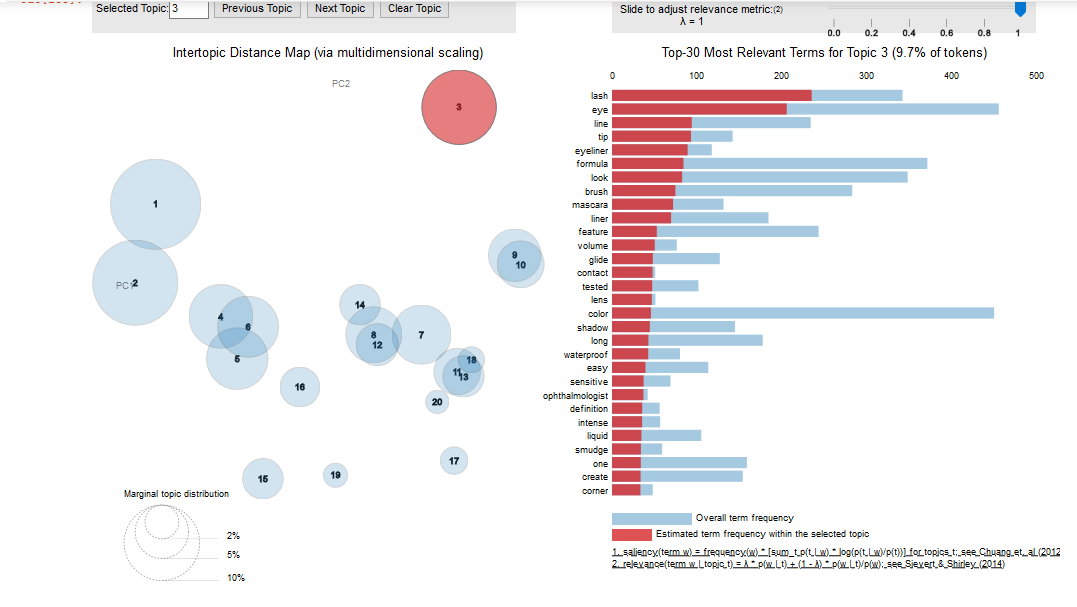

In [33]:
#Example of our lda gensim model
from IPython.display import Image
Image(filename="lda_gensim.png")

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
In this case is not a good enough topic model. In the next approach we used Scikit-Learn. 

#### LDA with Scikit-Learn

In [28]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

vectorized = vectorizer.fit_transform(text['description'])

In [29]:
model_lda = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1 
                                     )

lda_output = model_lda.fit_transform(vectorized)

In [30]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(model_lda, vectorized, vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
5       42.131062 -78.749969       1        1  15.493109
7       -9.934859 -89.483253       2        1  14.509088
6        6.507674 -41.602722       3        1  12.239941
16     -29.774748  46.241222       4        1  10.083952
4       74.004898  61.442486       5        1   8.443662
13     -50.668072   6.508484       6        1   8.441146
8       85.439751 -45.613400       7        1   7.997524
14      41.855190  23.003712       8        1   6.627451
17      12.901948  54.534599       9        1   5.515937
9      -67.115273  92.572136      10        1   3.726297
0      -60.571545 -78.992073      11        1   2.444179
15     -17.020338  96.351402      12        1   1.404671
12      91.827042   9.675216      13        1   1.302956
19      43.782440 -20.290585      14        1   0.527856
2       -2.770097   5.427330      15        1   0.348045
3      -79.530136  45.705872      16        1   0.341974
10     -85.697350 -34.795536      17        1   0.227230
18    -110.059319   8.055429      18        1   0.125703
11      35.379772  98.571175      19        1   0.113670
1      -35.439091 -34.610035      20        1   0.085610, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
1010  Default  327.000000               lash  327.000000  30.0000  30.0000
1006  Default  378.000000               lake  378.000000  29.0000  29.0000
1514  Default  298.000000                red  298.000000  28.0000  28.0000
1201  Default  168.000000               nail  168.000000  27.0000  27.0000
939   Default  572.000000         ingredient  572.000000  26.0000  26.0000
1060  Default  397.000000                lip  397.000000  25.0000  25.0000
1206  Default  402.000000            natural  402.000000  24.0000  24.0000
237   Default  199.000000               brow  199.000000  23.0000  23.0000
1613  Default  491.000000              shade  491.000000  22.0000  22.0000
644   Default  272.000000            extract  272.000000  21.0000  21.0000
1283  Default  526.000000              oxide  526.000000  20.0000  20.0000
1129  Default  237.000000              matte  237.000000  19.0000  19.0000
1269  Default  103.000000            organic  103.000000  18.0000  18.0000
182   Default  143.000000              blend  143.000000  17.0000  17.0000
1984  Default  230.000000                wax  230.000000  16.0000  16.0000
1333  Default  126.000000             pencil  126.000000  15.0000  15.0000
1122  Default  119.000000            mascara  119.000000  14.0000  14.0000
1660  Default  406.000000               skin  406.000000  13.0000  13.0000
239   Default  302.000000              brush  302.000000  12.0000  12.0000
743   Default  345.000000               free  345.000000  11.0000  11.0000
695   Default  200.000000             finish  200.000000  10.0000  10.0000
353   Default  458.000000              color  458.000000   9.0000   9.0000
1069  Default  244.000000               list  244.000000   8.0000   8.0000
357   Default  230.000000             colour  230.000000   7.0000   7.0000
649   Default  481.000000                eye  481.000000   6.0000   6.0000
790   Default  151.000000               glow  151.000000   5.0000   5.0000
281   Default  153.000000           carnauba  153.000000   4.0000   4.0000
960   Default  401.000000               iron  401.000000   3.0000   3.0000
294   Default  123.000000           cerifera  123.000000   2.0000   2.0000
653   Default  104.000000           eyeliner  104.000000   1.0000   1.0000
...       ...         ...                ...         ...      ...      ...
1863  Topic20    0.022327            topcoat    9.514598   1.0083  -7.5855
1973  Topic20    0.022178               wait    7.585198   1.2283  -7.5921
2028  Topic20    0.021902               zone    4.440934   1.7511  -7.6047
23 

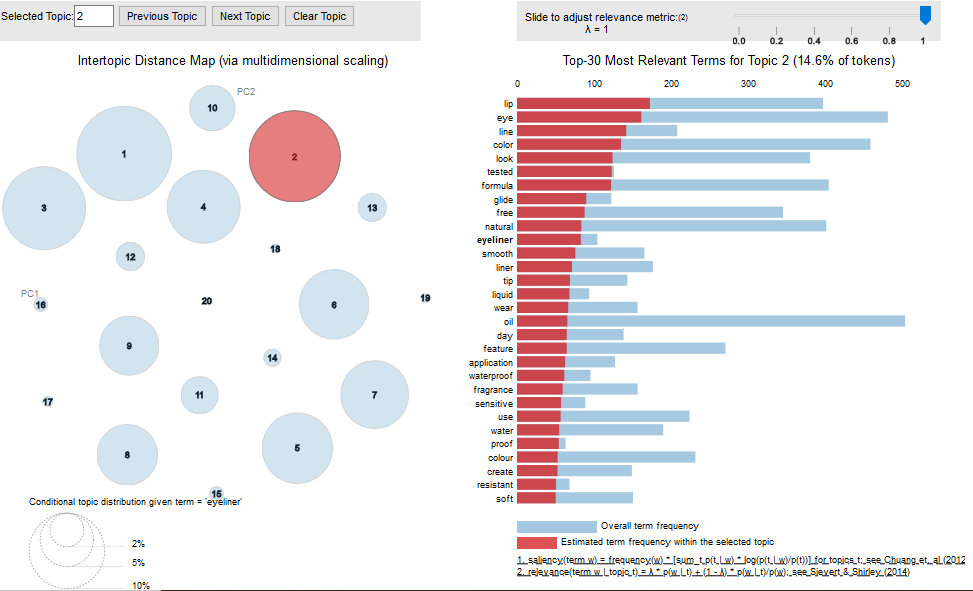

In [34]:
#Example of our lda scikit-learn model
Image(filename="lda_sklearn.png")

By the using this method we have successfully built a good looking topic model.

### Conclusion

We built a topic model using Gensim’s LDA and visualized the topics using pyLDAvis. Then we built LDA implementation by Scikit-learn and visualized it. By the using first method we have received a not good enough topic model. Next we applied second method and we got a good looking topic model.